sigma = 0.01 -> Outbreak rate: 1.070
sigma = 0.06 -> Outbreak rate: 1.420
sigma = 0.11 -> Outbreak rate: 1.970
sigma = 0.16 -> Outbreak rate: 2.330
sigma = 0.21 -> Outbreak rate: 2.590
sigma = 0.26 -> Outbreak rate: 3.435
sigma = 0.31 -> Outbreak rate: 3.665
sigma = 0.36 -> Outbreak rate: 4.355
sigma = 0.41 -> Outbreak rate: 4.490
sigma = 0.46 -> Outbreak rate: 4.925
sigma = 0.51 -> Outbreak rate: 5.055
sigma = 0.56 -> Outbreak rate: 4.940
sigma = 0.61 -> Outbreak rate: 4.900
sigma = 0.66 -> Outbreak rate: 4.575
sigma = 0.71 -> Outbreak rate: 1.590
sigma = 0.76 -> Outbreak rate: 0.020
sigma = 0.81 -> Outbreak rate: 0.000
sigma = 0.86 -> Outbreak rate: 0.000
sigma = 0.91 -> Outbreak rate: 0.000
sigma = 0.96 -> Outbreak rate: 0.000
sigma = 0.01 -> Outbreak rate: 1.125
sigma = 0.06 -> Outbreak rate: 1.430
sigma = 0.11 -> Outbreak rate: 1.900
sigma = 0.16 -> Outbreak rate: 2.410
sigma = 0.21 -> Outbreak rate: 2.990
sigma = 0.26 -> Outbreak rate: 3.710
sigma = 0.31 -> Outbreak rate: 4.165
s

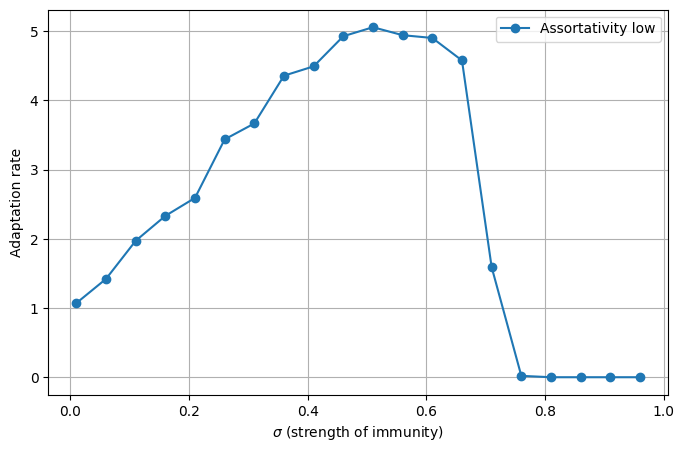

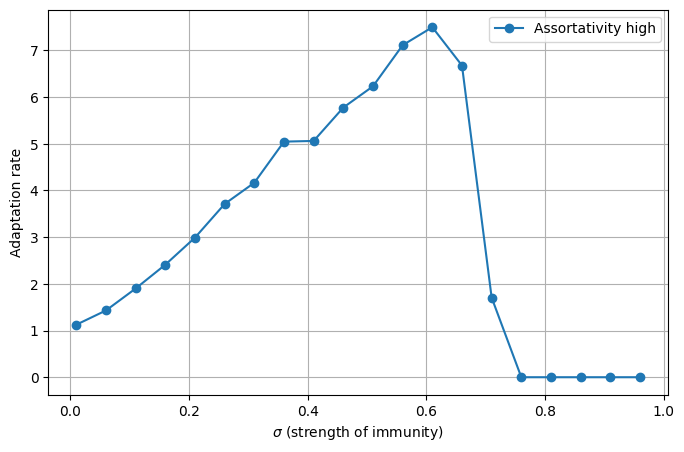

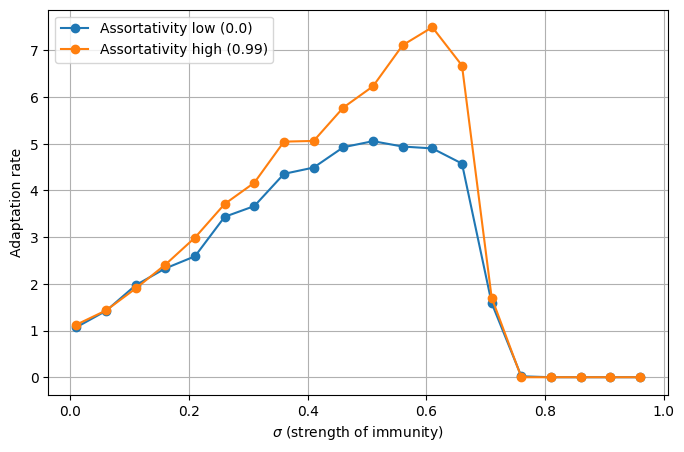

In [1]:
## 2
#For multiple sigma values:

import numpy as np
import random
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from numba import njit
from copy import deepcopy

@njit
def simulate_one_run(params):
    #beta = params.beta
    #p_a = params.p_a
    beta = params["beta"]
    a = params["a"]       # assortativity in [-1, 1]
    p_mut = params["p_mut"]
    sigma = params["sigma"]
    """
    Run one simulation realization with the given beta.
    Returns:
        peak_infected (int): Maximum number of infected individuals at any time step.
        outbreak (bool): True if peak_infected >= 20, False otherwise.
    """
    # -------------------------
    # Simulation Parameters
    # -------------------------
    N = params["N"]                   # total population size
    frac_vaccpos = 0.7      # fraction non-hesitant (vaccine-positive)
    #a = params["a"]       # assortativity in [-1, 1]
    #sigma = 0.99                # vaccine effectiveness factor (reduces transmission probability)
    gamma = params["gamma"]                # per time-step recovery probability
    contacts_per_infected = 1  # number of contacts per infected agent per time step
    dt = 0.5
    timesteps = int(350/dt)            # total simulation steps

    var2_outbreaks = 0
    var2_outbreak_threshold = N*0.01
    var2_outbreak_time_threshold = 400 # Days -- to place less emphasis on the transient!

    number_of_initial_infected = 1 # A few

    
    # -------------------------
    # Initialization
    # -------------------------
    # Determine vaccine status.
    vaccpos = np.random.rand(N) < frac_vaccpos

    # Epidemiological state:
    # Vaccinated individuals start as recovered from variant 1
    S = np.ones(N, dtype=np.int64)\
    


    I1 = np.zeros(N, dtype=np.int64)
    I2 = np.zeros(N, dtype=np.int64)
    R1 = np.zeros(N, dtype=np.int64)
    R2 = np.zeros(N, dtype=np.int64)
    V = np.zeros(N, dtype=np.int64)
    
    V[vaccpos] = 1 # Vaccinate the non-hesitant
    S[vaccpos] = 0

    # Seed the epidemic by infecting one hesitant individual.
    hesitant_indices = np.where(~vaccpos)[0]
    for pp in range(number_of_initial_infected):
        initial_infected = np.random.choice(hesitant_indices)
        I1[initial_infected] = 1
        S[initial_infected] = 0

    S_t = []
    I1_t = []
    I2_t = []
    R1_t = []
    R2_t = []
    times = []

    # -------------------------
    # Simulation Loop
    # -------------------------
    t = 0
    while t < timesteps and np.sum(I1 + I2) > 0:
        infected_indices_1 = np.where(I1 == 1)[0]
        infected_indices_2 = np.where(I2 == 1)[0]

        for i in infected_indices_1:
            vaccpos_status = vaccpos[i]
            # Compute the baseline fraction of individuals with the same vaccine attitude.
            f_same = np.sum(vaccpos == vaccpos_status) / N
            # Compute the probability to contact an individual of the same type.
            if a >= 0:
                p_same = f_same + a * (1 - f_same)
            else:
                p_same = f_same + a * f_same

            for _ in range(contacts_per_infected):
                if random.random() < p_same:
                    # Choose from the same vaccine-status group.
                    candidates = np.where(vaccpos == vaccpos_status)[0]
                else:
                    # Choose from the opposite group.
                    candidates = np.where(vaccpos != vaccpos_status)[0]
                
                # Avoid self-contact.
                candidates = candidates[candidates != i]
                if len(candidates) == 0:
                    continue
                contact = np.random.choice(candidates)

                # Transmission attempt:
                if S[contact] == 1: # Susceptible
                    if random.random() < beta * dt:
                        # Small risk of mutation to strain 2
                        if t > var2_outbreak_time_threshold:
                            if random.random() < p_mut:
                                I2[contact] = 1
                            else:
                                I1[contact] = 1
                        else:
                            I1[contact] = 1
                        S[contact] = 0
                elif (R1[contact] == 1 or V[contact] == 1) and (R2[contact] + I2[contact] + I1[contact]) == 0 :
                    # Recovered/protected; if recovered from strain 1, transmission probability is reduced.
                    effective_beta = (1.0 - sigma) * beta
                    if random.random() < effective_beta * dt:
                        # Breakthrough/reinfection
                        R1[contact] = 0
                        if t > var2_outbreak_time_threshold:
                            # Small risk of mutation to strain 2
                            if random.random() < p_mut:
                                I2[contact] = 1
                            else:
                                I1[contact] = 1

                        else: 
                            I1[contact] = 1
        

        for i in infected_indices_2:
            vaccpos_status = vaccpos[i]
            # Compute the baseline fraction of individuals with the same vaccine attitude.
            f_same = np.sum(vaccpos == vaccpos_status) / N
            # Compute the probability to contact an individual of the same type.
            if a >= 0:
                p_same = f_same + a * (1 - f_same)
            else:
                p_same = f_same + a * f_same

            for _ in range(contacts_per_infected):
                if random.random() < p_same:
                    # Choose from the same vaccine-status group.
                    candidates = np.where(vaccpos == vaccpos_status)[0]
                else:
                    # Choose from the opposite group.
                    candidates = np.where(vaccpos != vaccpos_status)[0]
                
                # Avoid self-contact.
                candidates = candidates[candidates != i]
                if len(candidates) == 0:
                    continue
                contact = np.random.choice(candidates)

                # ## 1. Universal, recovered different for the two strains
                # if (S[contact] == 1):
                #     if random.random() < beta * dt:
                #         I2[contact] = 1
                #         S[contact] = 0
                # elif (R1[contact] == 1 and V[contact] == 0) and (R2[contact] + I2[contact] + I1[contact]) == 0:
                #     # Recovered/protected; if just recovered from strain 1, transmission probability is NOT reduced.
                #     effective_beta = beta 
                #     if random.random() < effective_beta * dt:
                #         R1[contact] = 0
                #         I2[contact] = 1
                # elif (V[contact] == 1) and (R2[contact] + I2[contact] + I1[contact]) == 0:
                #     # If vaccinated, transmission probability IS reduced.
                #     effective_beta = beta * (1.0 - sigma)
                #     if random.random() < effective_beta * dt:
                #         R1[contact] = 0
                #         I2[contact] = 1

                ## 2. Vaccine not universal, recovered different for the two strains
                if (S[contact] == 1):
                    if random.random() < beta * dt:
                        I2[contact] = 1
                        S[contact] = 0
                elif (R1[contact] == 1 or V[contact] == 1) and (R2[contact] + I2[contact] + I1[contact]) == 0:
                    # Recovered/protected; if just recovered from strain 1, transmission probability is NOT reduced.
                    effective_beta = beta
                    if random.random() < effective_beta * dt:
                        R1[contact] = 0
                        I2[contact] = 1
       
                ## 3. Vaccine universal, recovered same for the two strains
                # if (S[contact] == 1):
                #     if random.random() < beta * dt:
                #         I2[contact] = 1
                #         S[contact] = 0
        
                # elif (V[contact] == 1 or R1[contact] == 0) and (R2[contact] + I2[contact] + I1[contact]) == 0:
                #     # If vaccinated, transmission probability IS reduced.
                #     effective_beta = beta * (1.0 - sigma)
                #     if random.random() < effective_beta * dt:
                #         R1[contact] = 0
                #         I2[contact] = 1
        
                # ## 4. Vaccine not universal, recovered same for the two strains
                # if (S[contact] == 1):
                #     if random.random() < beta * dt:
                #         I2[contact] = 1
                #         S[contact] = 0
                # elif (V[contact] == 1 and R1[contact] == 0) and (R2[contact] + I2[contact] + I1[contact]) == 0:
                #     # Vaccinated/protected; if just vaccinated from strain 1, transmission probability is NOT reduced.
                #     effective_beta = beta 
                #     if random.random() < effective_beta * dt:
                #         R1[contact] = 0
                #         I2[contact] = 1
                # elif (R1[contact] == 1) and (R2[contact] + I2[contact] + I1[contact]) == 0:
                #     # If recovered, transmission probability IS reduced.
                #     effective_beta = beta * (1.0 - sigma)
                #     if random.random() < effective_beta * dt:
                #         R1[contact] = 0
                #         I2[contact] = 1

        
        # Process recoveries.
        infected_indices_1 = np.where(I1 == 1)[0]
        infected_indices_2 = np.where(I2 == 1)[0]
        for i in infected_indices_1:
            if random.random() < gamma * dt:
                I1[i] = 0
                R1[i] = 1
        
        for i in infected_indices_2:
            if random.random() < gamma * dt:
                I2[i] = 0
                R2[i] = 1

        if np.sum(I2) > var2_outbreak_threshold:
            var2_outbreaks += 1
            infected_indices_2 = np.where(I2 == 1)[0]
            for i in infected_indices_2:
                # Move them to recovered from strain 1 so as to
                # disturb the dynamics as little as possible ...
                S[i] = 0
                I1[i] = 0
                R1[i] = 1
                I2[i] = 0
                R2[i] = 0
            recovered_indices_2 = np.where(R2 == 1)[0]
            for i in recovered_indices_2:
                # Move them to recovered from strain 1 so as to
                # disturb the dynamics as little as possible ...
                S[i] = 0
                I1[i] = 0
                R1[i] = 1
                I2[i] = 0
                R2[i] = 0
        
        I1_t.append(np.sum(I1))
        I2_t.append(np.sum(I2))
        R1_t.append(np.sum(R1))
        R2_t.append(np.sum(R2))
        S_t.append(np.sum(S))
        times.append(t*dt)

        t += 1

    S_t = np.array(S_t)
    I1_t = np.array(I1_t)
    I2_t = np.array(I2_t)
    R1_t = np.array(R1_t)
    R2_t = np.array(R2_t)
    
    times = np.array(times)
    peak_infected = max(I1_t + I2_t)
    outbreak = peak_infected >= 20
    return times, I1_t, I2_t, peak_infected, outbreak, var2_outbreaks
    #return times, S_t, I1_t, I2_t, R1_t, R2_t, peak_infected, outbreak, var2_outbreaks
    

def run_simulations_for_sigma(params, num_simulations=200, max_workers=20):
    """
    Runs multiple simulation realizations in parallel for a given besigmata.
    Returns:
        results (list of tuples): Each tuple is (peak_infected, outbreak).
    """
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(simulate_one_run, params) for _ in range(num_simulations)]
        for future in as_completed(futures):
            results.append(future.result())
    return results


# Define a structured array type for parameters
param_dtype = np.dtype([
    ('beta', np.float64),
    ('a', np.float64),
    ('sigma', np.float64),
    ('gamma', np.float64),
    ('p_mut', np.float64),
    ('N', np.int64),
])

params = np.zeros(1, dtype=param_dtype)[0]

params["N"] = 3000
params["a"] = 0
a_1 = params["a"]
params["beta"] = 0.8
params["gamma"] = 0.2
# Mutation risk:
params["p_mut"] = 5/params["N"]

n_sims = 200

outbreak_probabilities_1 = []

sigmas = np.arange(0.01, 1.01, 0.05)

# Loop over each sigma value.
for sigma in sigmas:
    params_loc = deepcopy(params)
    params_loc['sigma'] = sigma
    results = run_simulations_for_sigma(params_loc, num_simulations=n_sims, max_workers=8)
    #outbreak_flags = [res[1] for res in results]
    #fraction_outbreak = sum(outbreak_flags) / len(outbreak_flags)
    #outbreak_probabilities_1.append(fraction_outbreak)
    n_var2_outbreaks = [res[5] for res in results]
    outbreak_probabilities_1.append(np.mean(n_var2_outbreaks))
    print(f"sigma = {sigma:.2f} -> Outbreak rate: {np.mean(n_var2_outbreaks):.3f}")


# -------------------------
# Plotting the Results 1 # recall that the sigma parameter controls the strength of immunity (vaccinated/recovered)
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.array(sigmas), outbreak_probabilities_1, marker='o', linestyle='-', label=f"Assortativity low")
#plt.plot(np.array(betas)/params["gamma"], outbreak_probabilities_2, marker='o', linestyle='-', label=f"Assortativity low")
plt.xlabel(r"$\sigma$ (strength of immunity)")
plt.ylabel("Adaptation rate")
plt.grid(True)
#plt.ylim([-0.01, 1.02])
plt.legend()


params["a"] = 0.99
a_2 = params["a"]

outbreak_probabilities_2 = []

# Loop over each sigma value.
for sigma in sigmas:
    params_loc = deepcopy(params)
    params_loc['sigma'] = sigma
    results = run_simulations_for_sigma(params_loc, num_simulations=n_sims, max_workers=8)
    #outbreak_flags = [res[1] for res in results]
    #fraction_outbreak = sum(outbreak_flags) / len(outbreak_flags)
    #outbreak_probabilities_1.append(fraction_outbreak)
    n_var2_outbreaks = [res[5] for res in results]
    outbreak_probabilities_2.append(np.mean(n_var2_outbreaks))
    print(f"sigma = {sigma:.2f} -> Outbreak rate: {np.mean(n_var2_outbreaks):.3f}")


# -------------------------
# Plotting the Results 2 # recall that the sigma parameter controls the strength of immunity (vaccinated/recovered)
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.array(sigmas), outbreak_probabilities_2, marker='o', linestyle='-', label=f"Assortativity high")
#plt.plot(np.array(betas)/params["gamma"], outbreak_probabilities_2, marker='o', linestyle='-', label=f"Assortativity low")
plt.xlabel(r"$\sigma$ (strength of immunity)")
plt.ylabel("Adaptation rate")
plt.grid(True)
#plt.ylim([-0.01, 1.02])
plt.legend()


# -------------------------
# Plotting the Results 2 # recall that the sigma parameter controls the strength of immunity (vaccinated/recovered)
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.array(sigmas), outbreak_probabilities_1, marker='o', linestyle='-', label=f"Assortativity low ({a_1})")
plt.plot(np.array(sigmas), outbreak_probabilities_2, marker='o', linestyle='-', label=f"Assortativity high ({a_2})")
#plt.plot(np.array(betas)/params["gamma"], outbreak_probabilities_2, marker='o', linestyle='-', label=f"Assortativity low")
plt.xlabel(r"$\sigma$ (strength of immunity)")
plt.ylabel("Adaptation rate")
plt.grid(True)
#plt.ylim([-0.01, 1.02])
plt.legend()